In [1]:
using DelimitedFiles
using PyCall
using PyPlot
using Random
using Setfield
using Statistics
using ProgressMeter
using JLD2
using HDF5
using Printf
using FileIO
using DataStructures
using CUDA
using DrWatson

using Revise

using CMBLensing

┌ Info: Precompiling CMBLensing [b60c06c0-7e54-11e8-3788-4bd722d65317]
└ @ Base loading.jl:1278


In [2]:
Cℓ = camb(ωb=0.02268, ωc=0.1081, nₛ=0.961, H0=72.4, θs=nothing, logA=log(2.41*10), k_pivot=0.05, ℓmax=10000);

# Parallel setup

In [132]:
using Distributed, ClusterManagers
cluster_cookie("marius")
em = ElasticManager(addr=:auto, port=9312);

In [133]:
em

ElasticManager:
  Active workers : []
  Number of workers to be added  : 0
  Terminated workers : []
  Worker connect command : 
    /global/home/users/mariusmillea/src/julia-1.5.2/bin/julia --project=/global/home/users/mariusmillea/work/ptsrclens/Project.toml -e 'using ClusterManagers; ClusterManagers.elastic_worker("marius          ","10.0.0.24",9312)'

In [8]:
@everywhere using CUDA, CMBLensing

In [9]:
CMBLensing.assign_GPU_workers()

In [251]:
@everywhere workers() device!(mod(myid()-26,4))

In [10]:
for i in workers()
    @fetchfrom i println(gethostname(),"::",device())
end

      From worker 2:	n0302.savio2::CuDevice(0)
      From worker 3:	n0302.savio2::CuDevice(1)
      From worker 4:	n0302.savio2::CuDevice(2)
      From worker 5:	n0302.savio2::CuDevice(3)
      From worker 6:	n0299.savio2::CuDevice(0)
      From worker 7:	n0299.savio2::CuDevice(1)
      From worker 8:	n0299.savio2::CuDevice(2)
      From worker 9:	n0299.savio2::CuDevice(3)


# Load files

In [3]:
sims = 1:40;

In [58]:
fluxcuts = (2, 5, 10, Inf);

## Load originals

In [7]:
κs = @showprogress map(sims) do i
    ud_grade(FlatMap(h5read("dat/sehgal_maps_h5/radio_sources/cutouts/kappa_sehgal_patch$i.h5","map"), θpix=1//2), 2)
end

ϕs = map(κs) do κ
    -2*(∇²\κ)
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


In [8]:
gs_radio = Dict(map([90,148]) do freq
    freq => @showprogress map(sims) do i 
        ud_grade(
            FlatQUMap((h5read("dat/sehgal_maps_h5/radio_sources/cutouts/ps_sehgal_$(freq)ghz_$(pol)_patch$i.h5", "map") for pol in "QU")..., θpix=1//2), 
            2, 
            anti_aliasing=false, 
            deconv_pixwin=false
        )
    end
end);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16
Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


In [25]:
gs_ir = Dict(148 => @showprogress map(sims) do sim
    mapreduce(+, ["gal_S_$(S)" for S=1:9]) do bin
        ud_grade(
            FlatQUMap((Float32.(h5read("dat/sehgal_maps_h5/ir_sources/cutouts/ir_IR$(bin)_sehgal_$(pol)_patch$(sim).h5", "map")) for pol="QU")..., θpix=1//2), 2,
            anti_aliasing=false, deconv_pixwin=false
        )
    end
end);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:14


In [9]:
surveykeys = Dict(
    (90, :deep) => "beam2.3_noise0.48_lknee200_aknee2.0",
    (90, :wide) => "beam2.2_noise2.0_lknee700_aknee1.4",
    (148,:deep) => "beam1.5_noise0.68_lknee200_aknee2.0",
    (148,:wide) => "beam1.4_noise2.0_lknee700_aknee1.4"
);

In [10]:
Ms_radio = Dict(map(Iterators.product([:deep,:wide],[90,148],fluxcuts)) do (survey,freq,fluxcut)
    (survey,freq,fluxcut) => if fluxcut == Inf
        one.(sims)
    else
        @showprogress map(sims) do i
            filename = "dat/sehgal_maps_h5/radio_sources/cutouts/ps_mask_$(freq)ghz_$(fluxcut)mJy_$(surveykeys[freq,survey])_T_patch$(i).h5"
            if isfile(filename)
                M = ud_grade(FlatMap(Float32.(h5read(filename,"map")),θpix=1//2), 2, anti_aliasing=false, deconv_pixwin=false)
                Diagonal(FlatQUMap(M,M))
            else
                nothing
            end
        end
    end
end);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


In [28]:
@save "dat/sehgal_maps_h5/cutouts.jld2" ϕs κs gs_ir gs_radio Ms_radio;

## Load pre-processed

In [30]:
@load "dat/sehgal_maps_h5/cutouts.jld2"

5-element Array{Symbol,1}:
 :ϕs
 :κs
 :gs_ir
 :gs_radio
 :Ms_radio

In [31]:
# ϕs = cu.(ϕs)
# κs = cu.(κs)
# gs_ir = cu.(gs_ir)
# gs_radio = cu.(gs_radio)
# Ms_radio = Dict(2 => cu.(Ms_radio[2]), 5 => cu.(Ms_radio[5]), 10 => cu.(Ms_radio[10]), Inf => Ms_radio[Inf]);

# Check power

In [32]:
μKarcmin_gs_radio = sort(Dict(map(collect(Ms_radio)) do ((survey,freq,fluxcut), Ms)
    (survey,freq,fluxcut) => if !(nothing in Ms)
        mean(sims) do i
            sqrt(mean(get_Cℓ(Ms[i] * gs_radio[freq][i], which=:QQ)[1000:2000]) / deg2rad(1/60)^2)
        end
    end
end))

OrderedDict{Tuple{Symbol,Int64,Real},Union{Nothing, Float64}} with 16 entries:
  (:deep, 90, 2)    => nothing
  (:deep, 90, 5)    => nothing
  (:deep, 90, 10)   => 0.183897
  (:deep, 90, Inf)  => 1.46472
  (:deep, 148, 2)   => 0.0346629
  (:deep, 148, 5)   => 0.0579392
  (:deep, 148, 10)  => 0.080185
  (:deep, 148, Inf) => 0.632798
  (:wide, 90, 2)    => 0.0752406
  (:wide, 90, 5)    => 0.131259
  (:wide, 90, 10)   => 0.185232
  (:wide, 90, Inf)  => 1.46472
  (:wide, 148, 2)   => nothing
  (:wide, 148, 5)   => nothing
  (:wide, 148, 10)  => 0.0824392
  (:wide, 148, Inf) => 0.632798

In [33]:
tab = pyimport("pandas").DataFrame(Dict(
    148 => Dict(fluxcut => μKarcmin_gs_radio[:deep,148,fluxcut] for fluxcut in [Inf,10,5,2]),
    90  => Dict(fluxcut => μKarcmin_gs_radio[:wide,90, fluxcut] for fluxcut in [Inf,10,5,2]),
)).T
println(tab.to_latex(float_format="%.2f"))
tab

\begin{tabular}{lrrrr}
\toprule
{} &  inf  &  10.0 &  2.0  &  5.0  \\
\midrule
148 &  0.63 &  0.08 &  0.03 &  0.06 \\
90  &  1.46 &  0.19 &  0.08 &  0.13 \\
\bottomrule
\end{tabular}



,inf,10.0,2.0,5.0
148,0.632798,0.080185,0.034663,0.057939
90,1.464721,0.185232,0.075241,0.131259


In [34]:
μKarcmin_gs_ir = Dict(148 => mean(sims) do i
    sqrt(mean(get_Cℓ(gs_ir[148][i], which=:QQ)[1000:2000]) / deg2rad(1/60)^2)
end)

Dict{Int64,Float64} with 1 entry:
  148 => 0.0740397

In [35]:
LP = LowPass(1100,Δℓ=200).diag.Wℓ
HP = HighPass(901,Δℓ=200).diag.Wℓ
Cℓϕϕ = CMBLensing.extrapolate_Cℓs(
    2:10000, 
    2:6000, 
    nan2zero.((LP * Cℓ.total.ϕϕ)[2:6000]) + nan2zero.((HP * CMBLensing.smooth(mean(get_Cℓ(ϕ) for ϕ in ϕs), xscale=:log, yscale=:log))[2:6000])
);

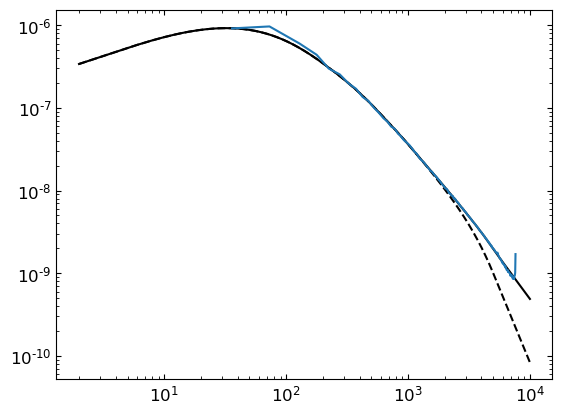

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x2ab8ce499c90>

In [36]:
loglog(ℓ⁴*Cℓϕϕ,"k")
loglog(ℓ⁴*Cℓ.total.ϕϕ,"k--")
loglog(mean(get_ℓ⁴Cℓ(ϕ) for ϕ in ϕs))

In [37]:
@set! Cℓ.total.ϕϕ = Cℓϕϕ;

In [21]:
# @save "Cl.jld2" Cℓ

# Reconstruct

In [134]:
function get_MAPs(;Ms, gs, ϕs, noise_kwargs, ℓmax_data, fluxcut, polfrac_scale, ℓedges, μKarcmin_g, Nbatch=16, MAPs=nothing)
        
    @unpack ds = load_sim_dataset(;
        Cℓ = Cℓ,
        θpix = 2,
        Nside = 300,
        pol = :P,
        bandpass_mask = LowPass(ℓmax_data),
        Nbatch = Nbatch,
        noise_kwargs...
    )
    @unpack B = ds
    ds.Cϕ = Cℓ_to_Cov(ϕs[1], (Cℓ.total.ϕϕ, ℓedges, :Aϕ));

    μKarcmin_g = mean(sqrt(mean(get_Cℓ(Ms[fluxcut][i] * gs[i], which=:QQ)[1000:2000]) / deg2rad(1/60)^2) for i=sims)
    Cℓg = noiseCℓs(μKarcminT=polfrac_scale*μKarcmin_g/√2, beamFWHM=0, ℓknee=0)
    Cg = Cℓ_to_Cov(Flat(Nside=300, θpix=2), Float32, S2, Cℓg.EE, Cℓg.BB)
    
    @showprogress pmap(sims) do sim

        sim′ = mod(sim,maximum(sims))+1

        Dict(map([

            (:nofg,     :fgcov, 0,        Ms[fluxcut][sim],  ϕs[sim]),
            (:corrfg,   :fgcov, gs[sim] , Ms[fluxcut][sim],  ϕs[sim]),
            (:uncorrfg, :fgcov, gs[sim′], Ms[fluxcut][sim′], ϕs[sim]),
#             (:nofg,     :nocov, 0,        Ms[fluxcut][sim],  ϕs[sim]),
#             (:corrfg,   :nocov, gs[sim] , Ms[fluxcut][sim],  ϕs[sim]),
#             (:uncorrfg, :nocov, gs[sim′], Ms[fluxcut][sim′], ϕs[sim])

        ]) do (g_in_data, g_in_cov, g, M, ϕ)

            ds′ = resimulate(ds, ϕ=ϕ, seed=sim).ds
            if g_in_cov != :nocov
                ds′.Cn += polfrac_scale^2*B*Cg*B'
            end
            if g_in_data != :nofg
                ds′.d  += polfrac_scale*B*M*g
            end
            ds′ = cu(ds′)

            (g_in_data,g_in_cov) => 
                try
                    if MAPs == nothing
                        fJ,ϕJ = MAP_joint(
                            ds′,
                            Nϕ       = :qe,
                            nsteps   = 30,
                            progress = false,
                        )
                    else
                        fJ, ϕJ = cu.(MAPs[sim][g_in_data,g_in_cov][1:2])
                    end
                    g = gradient(Aϕ -> lnP(0,fJ,ϕJ,(Aϕ=Aϕ,),ds′), ones(Float32,length(ℓedges)-1))[1]
                    (f=cpu(fJ), ϕ=cpu(ϕJ), g=g)
                catch err
                    rethrow(err)
                    @warn "$sim $g_in_data $g_in_cov"
                    nothing
                end

        end...)

    end
    
end

get_MAPs (generic function with 1 method)

In [135]:
ℓedges = [2:100:500; round.(Int, 10 .^ range(log10(502), log10(6000), length=10))];

In [136]:
noises = Dict(
    (:deep, 90)  => (μKarcminT=0.68/√2, beamFWHM=2.3, ℓknee=200, αknee=2),
    (:wide, 90)  => (μKarcminT=2.9/√2,  beamFWHM=2.2, ℓknee=700, αknee=1.4),
    (:deep, 148) => (μKarcminT=0.96/√2, beamFWHM=1.5, ℓknee=200, αknee=2),
    (:wide, 148) => (μKarcminT=2.8/√2,  beamFWHM=1.4, ℓknee=700, αknee=1.4),
);

In [137]:
ℓmax_datas = [3000, 5000]
polfrac_scales = [1, 2]
freqs = [90, 148]
surveys = [:deep, :wide];

In [138]:
configs = let fluxcuts = [5]
    collect(skipmissing(map(Iterators.product(surveys,freqs,ℓmax_datas,fluxcuts,polfrac_scales)) do (survey,freq,ℓmax_data,fluxcut,polfrac_scale)
        filename = datadir("MAPs", savename((;survey,freq,ℓmax_data,fluxcut,polfrac_scale), "jld2"))
        if !isfile(filename)
            (survey,freq,ℓmax_data,fluxcut,polfrac_scale,filename)
        else
            missing
        end
    end))
end

16-element Array{Tuple{Symbol,Int64,Int64,Int64,Int64,String},1}:
 (:deep, 90, 3000, 5, 1, "/global/home/users/mariusmillea/work/ptsrclens/data/MAPs/fluxcut=5_freq=90_polfrac_scale=1_survey=deep_ℓmax_data=3000.jld2")
 (:wide, 90, 3000, 5, 1, "/global/home/users/mariusmillea/work/ptsrclens/data/MAPs/fluxcut=5_freq=90_polfrac_scale=1_survey=wide_ℓmax_data=3000.jld2")
 (:deep, 148, 3000, 5, 1, "/global/home/users/mariusmillea/work/ptsrclens/data/MAPs/fluxcut=5_freq=148_polfrac_scale=1_survey=deep_ℓmax_data=3000.jld2")
 (:wide, 148, 3000, 5, 1, "/global/home/users/mariusmillea/work/ptsrclens/data/MAPs/fluxcut=5_freq=148_polfrac_scale=1_survey=wide_ℓmax_data=3000.jld2")
 (:deep, 90, 5000, 5, 1, "/global/home/users/mariusmillea/work/ptsrclens/data/MAPs/fluxcut=5_freq=90_polfrac_scale=1_survey=deep_ℓmax_data=5000.jld2")
 (:wide, 90, 5000, 5, 1, "/global/home/users/mariusmillea/work/ptsrclens/data/MAPs/fluxcut=5_freq=90_polfrac_scale=1_survey=wide_ℓmax_data=5000.jld2")
 (:deep, 148, 5000, 5, 1

In [ ]:
map(configs) do (survey,freq,ℓmax_data,fluxcut,polfrac_scale,filename)
    MAPs = get_MAPs(;
        Ms=Ms_radio[survey,freq,fluxcut], gs=gs_radio[freq], ϕs, noise_kwargs=noises[survey,freq], ℓmax_data, fluxcut, 
        polfrac_scale, ℓedges, μKarcmin_g=μKarcmin_gs_radio[survey,freq,fluxcut], Nbatch=16
    )
    save(filename, "MAPs", MAPs)
end